## Import thư viện

In [2]:
# Khai báo dữ liệu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from xgboost import plot_importance, plot_tree
import sqlalchemy
import warnings
warnings.filterwarnings('ignore')

In [3]:
url = "mysql+mysqldb://root:@localhost/weather_hn"
engine = sqlalchemy.create_engine(url)

## Load dữ liệu

In [4]:
df = pd.read_csv("weather.csv")
df.head()

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,date
0,Bac Lieu,27,22,17,NNE,6.9,90,71,1010,2009-01-01
1,Bac Lieu,31,25,20,ENE,0.0,64,24,1010,2010-01-01
2,Bac Lieu,29,24,14,E,0.0,75,45,1008,2011-01-01
3,Bac Lieu,30,24,30,E,0.0,79,52,1012,2012-01-01
4,Bac Lieu,31,25,20,ENE,0.0,70,24,1010,2013-01-01


In [7]:
# Lọc ra dữ liệu của Hà Nội
df_ha_noi = df[df['province'].isin(['Ha Noi'])] 

# Sắp xếp lại giá trị theo thứ tự ngày
df_ha_noi.sort_values(by=['date'])

# Tính nhiệt độ trung bình
# df_ha_noi['temp'] = (df_ha_noi['min'] + df_ha_noi['max']) / 2 

# Xóa cột min, max
# df_ha_noi.drop(['min', 'max'], axis=1, inplace=True) 

# Tách ngày, tháng, năm ra từ cột date
df_ha_noi['day'] = df_ha_noi['date'].apply(lambda x: x.split('-')[2]).astype(int)
df_ha_noi['month'] = df_ha_noi['date'].apply(lambda x: x.split('-')[1]).astype(int)
df_ha_noi['year'] = df_ha_noi['date'].apply(lambda x: x.split('-')[0]).astype(int)

# Đặt lại index là cột date
df_ha_noi = df_ha_noi.set_index("date")

# Sắp xếp lại dữ liệu theo thứ tự ngày
df_ha_noi.sort_index(inplace=True)
df_ha_noi.head()

C:\Users\nguyen\AppData\Local\Temp\ipykernel_20144\1160920101.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ha_noi['day'] = df_ha_noi['date'].apply(lambda x: x.split('-')[2]).astype(int)
C:\Users\nguyen\AppData\Local\Temp\ipykernel_20144\1160920101.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ha_noi['month'] = df_ha_noi['date'].apply(lambda x: x.split('-')[1]).astype(int)
C:\Users\nguyen\AppData\Local\Temp\ipykernel_20144\1160920101.py:16: SettingWithCopyWarning: 
A value is trying to b

,province,max,min,wind,wind_d,rain,humidi,cloud,pressure,day,month,year
date,,,,,,,,,,,,
2009-01-01,Ha Noi,19,12,6,NNE,0.0,70,44,1025,1,1,2009
2009-01-02,Ha Noi,18,12,6,ESE,0.5,65,28,1025,2,1,2009
2009-01-03,Ha Noi,20,13,5,ESE,0.7,74,40,1022,3,1,2009
2009-01-04,Ha Noi,25,12,5,SSW,0.0,81,46,1018,4,1,2009
2009-01-05,Ha Noi,23,14,5,S,1.3,90,75,1017,5,1,2009


In [ ]:
# save dataframe to csv
df_ha_noi.to_csv('weather_ha_noi.csv')

In [10]:
df_hn_copy = df_ha_noi.copy()
df_hn_copy['isTrain'] = 1

df_hn_copy.to_sql('weather', con=engine, if_exists='replace', index=True)

4549

## Mô phỏng dữ liệu

In [11]:
df_ha_noi.describe()

,max,min,wind,rain,humidi,cloud,pressure,day,month,year
count,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000,4549.000000
mean,29.489998,21.721257,8.382282,4.177028,74.206419,50.408661,1011.211695,15.692680,6.407342,2014.741482
std,6.217772,4.911990,3.186597,8.931418,10.925099,26.183295,6.898611,8.793042,3.451454,3.603904
min,7.000000,2.000000,2.000000,0.000000,28.000000,0.000000,993.000000,1.000000,1.000000,2009.000000
25%,25.000000,19.000000,6.000000,0.000000,68.000000,30.000000,1005.000000,8.000000,3.000000,2012.000000
50%,30.000000,23.000000,8.000000,0.900000,76.000000,49.000000,1011.000000,16.000000,6.000000,2015.000000
75%,34.000000,26.000000,10.000000,4.500000,82.000000,71.000000,1016.000000,23.000000,9.000000,2018.000000
max,45.000000,32.000000,25.000000,203.200000,97.000000,100.000000,1037.000000,31.000000,12.000000,2021.000000


<AxesSubplot:xlabel='date'>

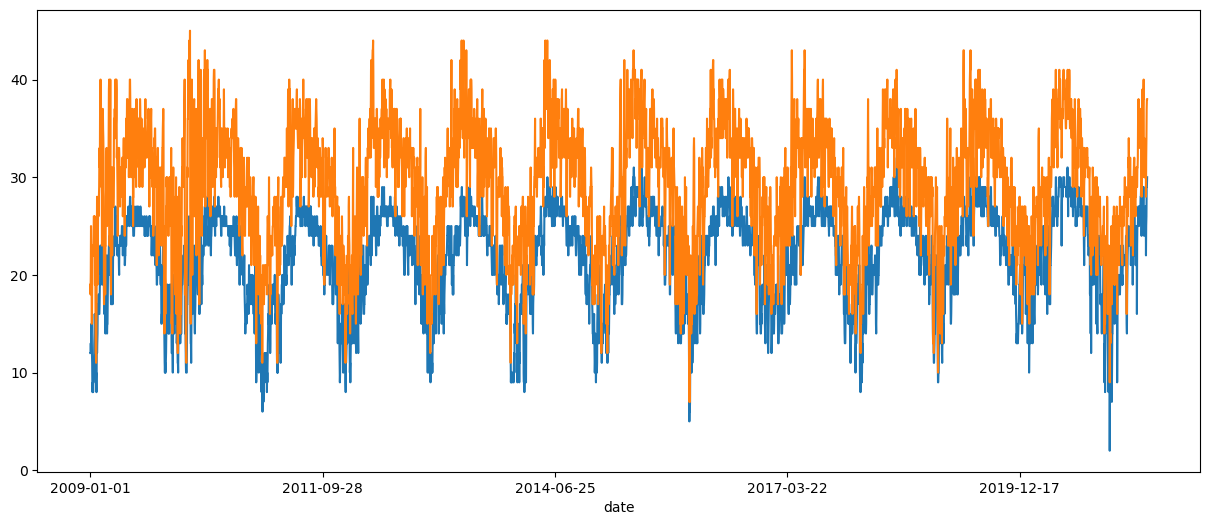

In [14]:
df_ha_noi['min'].plot(figsize=(15, 6))
df_ha_noi['max'].plot(figsize=(15, 6))

## Tạo mô hình

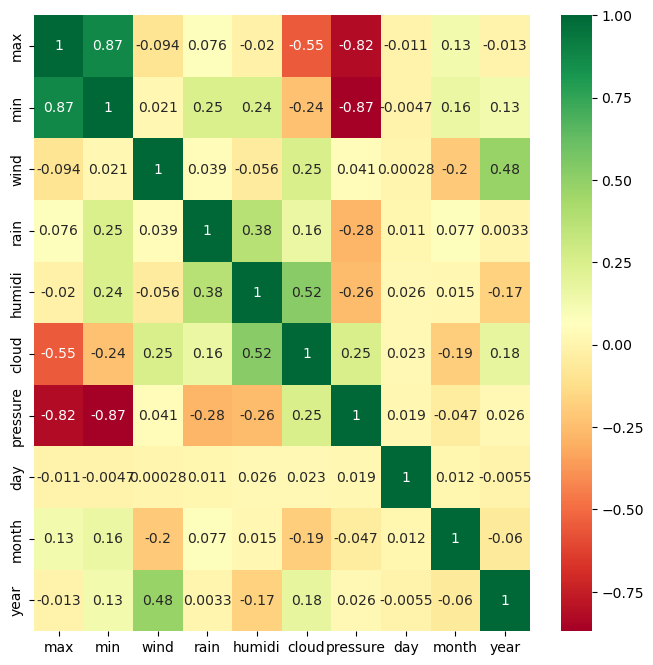

In [15]:
corr = df_ha_noi.corr()
plt.subplots(figsize=(8, 8))
sns.heatmap(corr, cmap='RdYlGn', annot=True)
plt.show()

In [18]:
# temp min corr
corr['min'].to_sql('temp_min_corr', con=engine, if_exists='replace', index=True)
# temp max corr
corr['max'].to_sql('temp_max_corr', con=engine, if_exists='replace', index=True)

10

In [19]:
# Import train_test_split from pmdarima.model_selection
from pmdarima.model_selection import train_test_split

# Split data into training and testing sets
x_train,x_test = train_test_split(df_ha_noi, train_size=0.8)

In [21]:
X_train = x_train[['day','month','year','rain','pressure']]
y_train = x_train['min']
X_test = x_test[['day','month','year','rain','pressure']]
y_test = x_test['min']

In [36]:
X_train = x_train[['day','month','year']]
y_train = x_train['max']
X_test = x_test[['day','month','year']]
y_test = x_test['max']

In [37]:
reg = xgb.XGBRegressor(n_estimators=1500, booster='dart', n_jobs=8, importance_type='weight')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # too much logs 

c:\Users\nguyen\.conda\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.5, booster='dart', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type='weight',
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

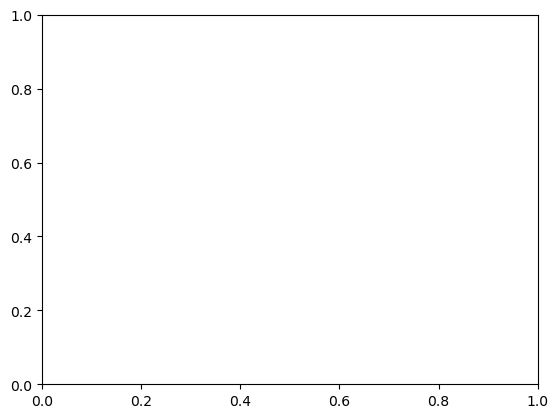

In [38]:
# plot tree
plot_tree(reg, num_trees=0)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

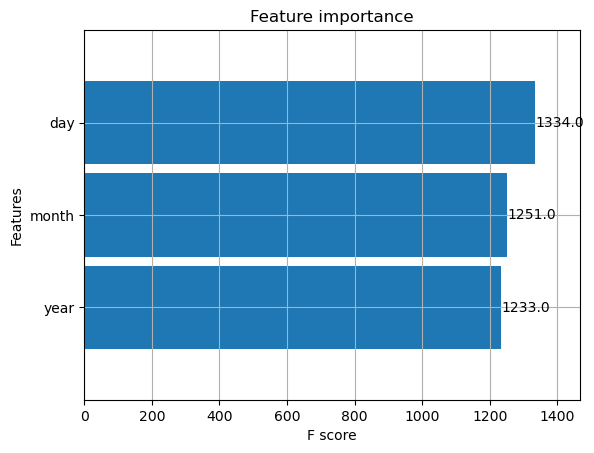

In [39]:
plot_importance(reg, height=0.9)

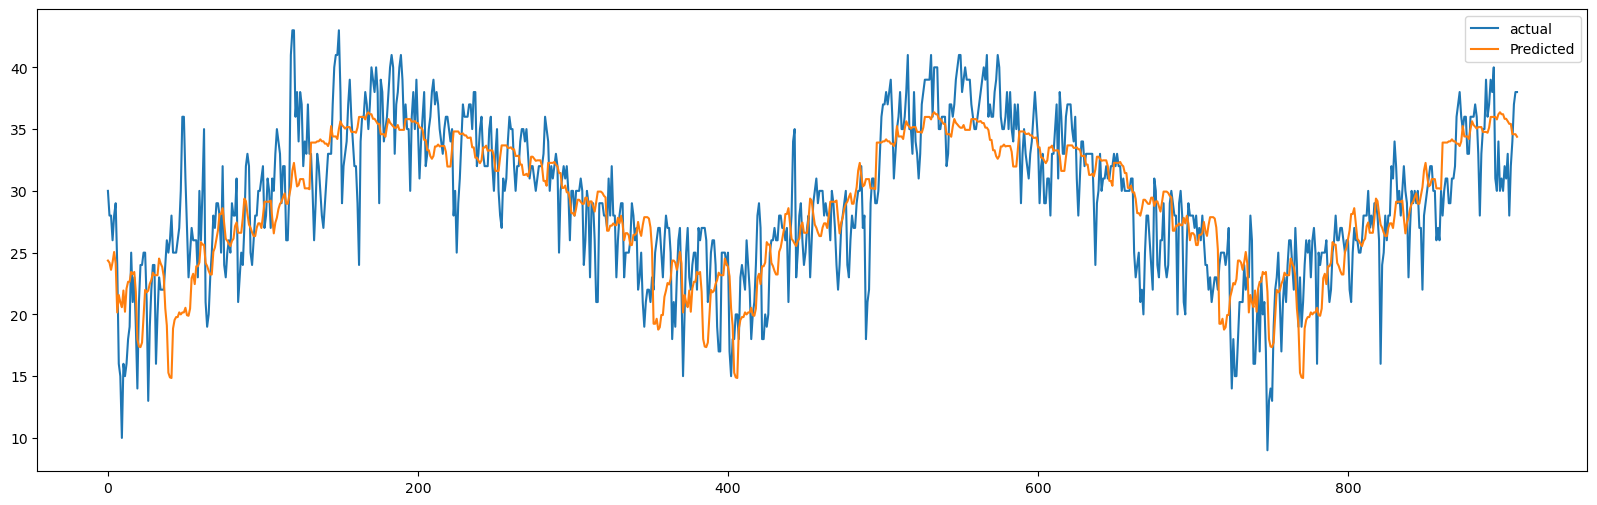

In [40]:
pred = reg.predict(X_test)
plt.figure(figsize=(20, 6))
# reset index to plot
# 

plt.plot(y_test.reset_index(drop=True), label='actual')

plt.plot(pred, label='Predicted')

plt.legend()
plt.show()


In [41]:
# r2 and rmse
from sklearn.metrics import r2_score, mean_squared_error
print('r2 score: ', r2_score(y_test, pred))
print('rmse: ', np.sqrt(mean_squared_error(y_test, pred)))


r2 score:  0.583326780547422
rmse:  3.888962038256778


In [29]:
# make function to predict
def predict(day, month, year):
    input = np.array([day, month, year]).reshape(1, -1)
    return reg.predict(input)
predict(12, 11, 2022)

array([21.660887], dtype=float32)

In [42]:
# predict to now
date = pd.date_range(start='2020-01-01', end='2022-12-31').to_frame().reset_index(drop=True).rename(columns={0: 'date'})
# predict temp min
date['day'] = date['date'].apply(lambda x: x.day).astype(int)
date['month'] = date['date'].apply(lambda x: x.month).astype(int)
date['year'] = date['date'].apply(lambda x: x.year).astype(int)
date['max'] = date.apply(lambda x: predict(x['day'], x['month'], x['year'])[0], axis=1)



In [43]:
date.to_sql('temp_max_predict', con=engine, if_exists='replace', index=True)

1096

## Dự đoán lượng mưa

c:\Users\nguyen\.conda\envs\tf-gpu\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


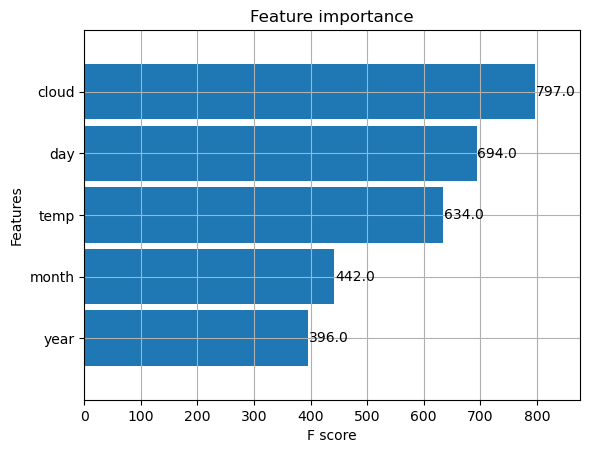

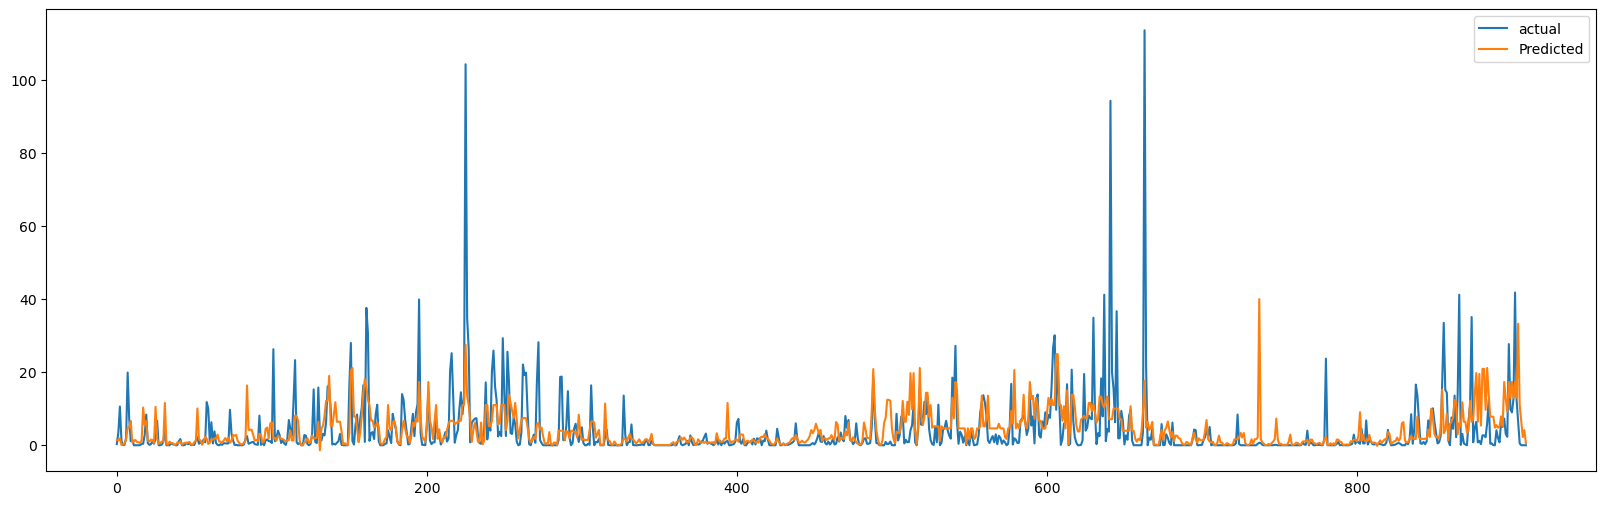

In [73]:
# This is a function that returns the xgboost model.
# The function takes in the training and test dataframes, x_col which is the list of columns used as features,
# and y_col which is the list of columns used as labels.
# The function returns the xgboost model.

def xgTrain(x_train, x_test, x_col, y_col):
    X_train = x_train[x_col]
    y_train = x_train[y_col]
    X_test = x_test[x_col]
    y_test = x_test[y_col]
    reg = xgb.XGBRegressor(n_estimators=1500, booster='dart', n_jobs=8, importance_type='weight')
   
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
        verbose=False) # too much logs
    plot_importance(reg, height=0.9)

    pred = reg.predict(X_test)
    plt.figure(figsize=(20, 6))   
    plt.plot(y_test.reset_index(drop=True), label='actual')
    plt.plot(pred, label='Predicted')
    plt.legend()
    plt.show()
    return reg

rain_model = xgTrain(x_train, x_test, ['day','month','year','temp','cloud'], 'rain')
